# Exp 019: Decoding-based grammar control
This experiments sets up decoding-strategies for grammar-controlled educational text generation.

In [49]:
from dotenv import load_dotenv
load_dotenv()
import os
os.environ['CACHE_DIR'] = os.environ['FAST_CACHE_DIR'].replace("%SLURM_JOB_ID%", os.getenv('SLURM_JOB_ID')) # speed up model loading

import sys
sys.path.append(f'../source')
import helpers
import models
import evaluation
import importlib
#importlib.reload(models)

import torch
from torch.utils.data import DataLoader, TensorDataset
import datasets
datasets.disable_caching()
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import seaborn as sns

## Ground-truth partial scoring
For an efficient decoding, partial sequences should already score high. Then, we do not need to train future discriminators anymore.

In [2]:
# params
preprossed_dataset_file = '../data/SFT_data.jsonl'
batch_size=128
max_len = 64

In [ ]:
# data
dataset = datasets.load_dataset('json', data_files=preprossed_dataset_file, split='train')

In [38]:
all_constraints = list(np.unique(dataset['constraints']))
partial_scores = {}
max_indices = {}

for nr in tqdm(all_constraints, desc="Constraints"):
    subset = dataset.filter(lambda item: item['constraints']==nr)
    encoded_inputs = models.bert_tokenizer(subset['response'][:20], return_tensors='pt', max_length=64, padding='max_length', truncation=True)
    partial_scores[nr] = np.zeros(encoded_inputs['input_ids'].shape)
    classifier = models.load_classifier(nr, 'corpus_training')
    
    for i in tqdm(range(partial_scores[nr].shape[1]), total=partial_scores[nr].shape[1], leave=False, desc="Sequence lengths"):
        corpus_dataset = TensorDataset(encoded_inputs['input_ids'][:,:i+1], encoded_inputs['attention_mask'][:,:i+1])
        corpus_dataloader = DataLoader(corpus_dataset, batch_size=batch_size, shuffle=False)
        scores = models.score_corpus(classifier, corpus_dataloader, max_positive=1e10, max_batches=10000, progress=False)
        partial_scores[nr][:,i] = scores[0]
    max_indices[nr] = scores[1] # only save max token for the entire sequence

Constraints:   0%|          | 0/59 [00:00<?, ?it/s]

Sequence lengths:   0%|          | 0/64 [00:00<?, ?it/s]

Sequence lengths:   0%|          | 0/64 [00:00<?, ?it/s]

Sequence lengths:   0%|          | 0/64 [00:00<?, ?it/s]

Sequence lengths:   0%|          | 0/64 [00:00<?, ?it/s]

Sequence lengths:   0%|          | 0/64 [00:00<?, ?it/s]

Sequence lengths:   0%|          | 0/64 [00:00<?, ?it/s]

Sequence lengths:   0%|          | 0/64 [00:00<?, ?it/s]

Sequence lengths:   0%|          | 0/64 [00:00<?, ?it/s]

Sequence lengths:   0%|          | 0/64 [00:00<?, ?it/s]

Sequence lengths:   0%|          | 0/64 [00:00<?, ?it/s]

Sequence lengths:   0%|          | 0/64 [00:00<?, ?it/s]

Sequence lengths:   0%|          | 0/64 [00:00<?, ?it/s]

Sequence lengths:   0%|          | 0/64 [00:00<?, ?it/s]

Sequence lengths:   0%|          | 0/64 [00:00<?, ?it/s]

Sequence lengths:   0%|          | 0/64 [00:00<?, ?it/s]

Sequence lengths:   0%|          | 0/64 [00:00<?, ?it/s]

Sequence lengths:   0%|          | 0/64 [00:00<?, ?it/s]

Sequence lengths:   0%|          | 0/64 [00:00<?, ?it/s]

Sequence lengths:   0%|          | 0/64 [00:00<?, ?it/s]

Sequence lengths:   0%|          | 0/64 [00:00<?, ?it/s]

Sequence lengths:   0%|          | 0/64 [00:00<?, ?it/s]

Sequence lengths:   0%|          | 0/64 [00:00<?, ?it/s]

Sequence lengths:   0%|          | 0/64 [00:00<?, ?it/s]

Sequence lengths:   0%|          | 0/64 [00:00<?, ?it/s]

Sequence lengths:   0%|          | 0/64 [00:00<?, ?it/s]

Sequence lengths:   0%|          | 0/64 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [28]:
def get_aligned_scores(scores, max_tokens):
    #threshold_indices = np.argmax(data >= 0.5, axis=1)
    max_index = max(max_tokens)
    target_length = scores.shape[1] + max_index
    padded_data = []
    
    for i, row in enumerate(scores):
        shift = max_index - max_tokens[i]
        padded_row = np.pad(row, (shift, 0), mode='constant', constant_values=(0, 0))
        right_padding = target_length - len(padded_row)
        if right_padding > 0:
            padded_row = np.pad(padded_row, (0, right_padding), mode='constant', constant_values=(0, row[-1]))
        padded_data.append(padded_row)
    
    return np.array(padded_data)

  0%|          | 0/26 [00:00<?, ?it/s]

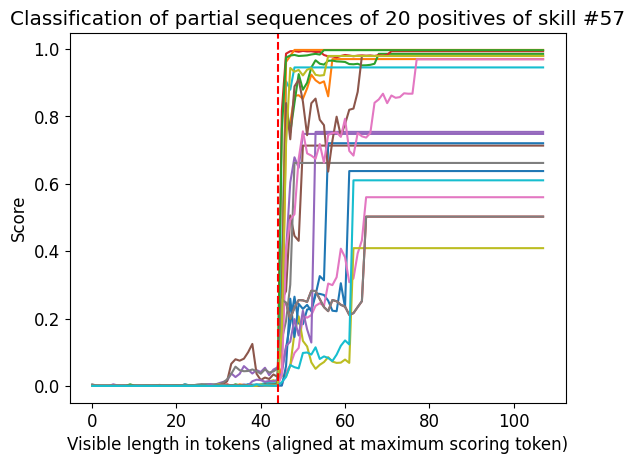

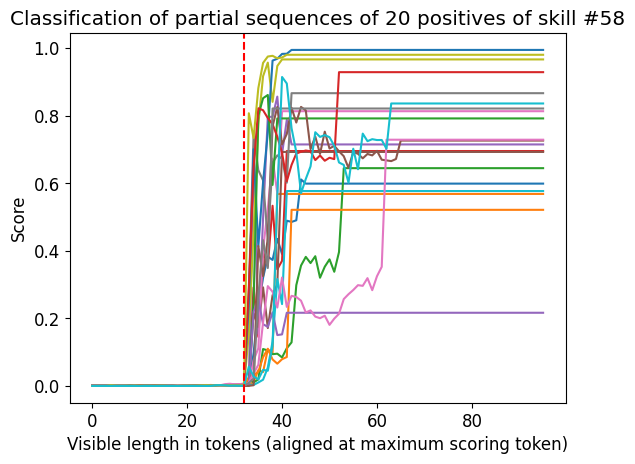

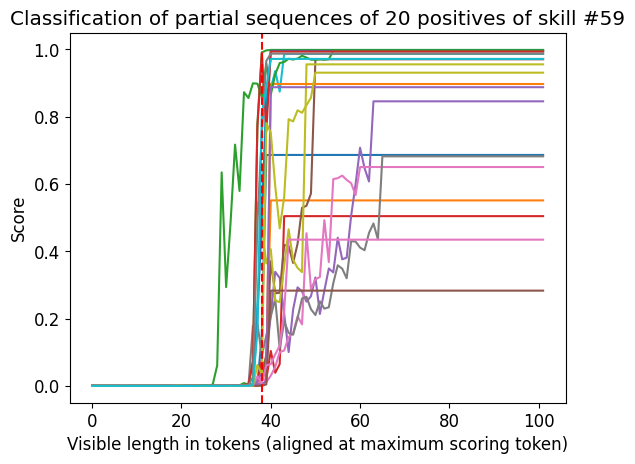

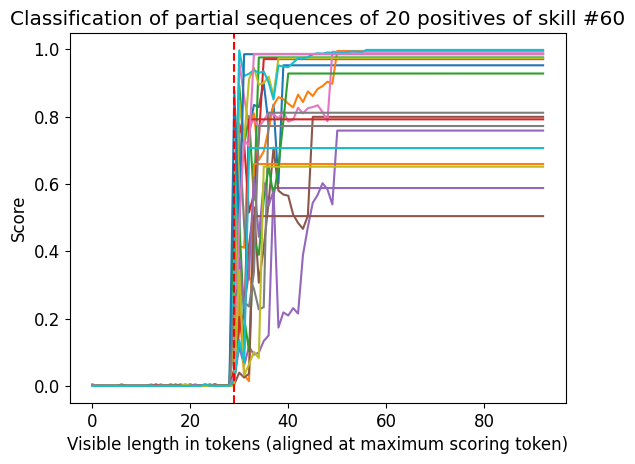

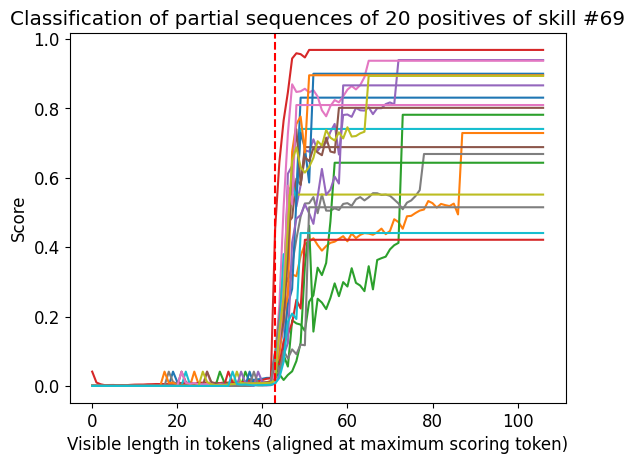

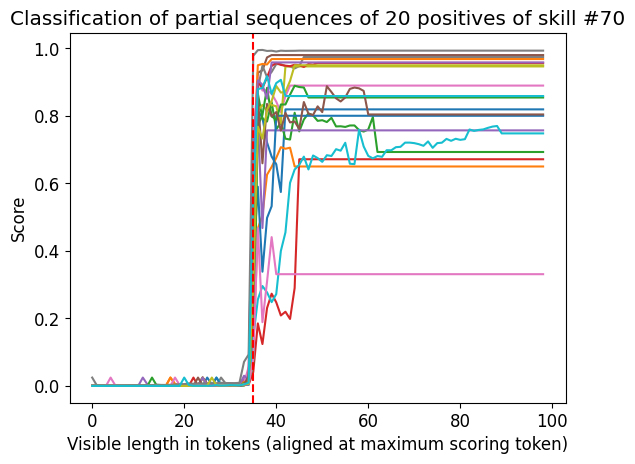

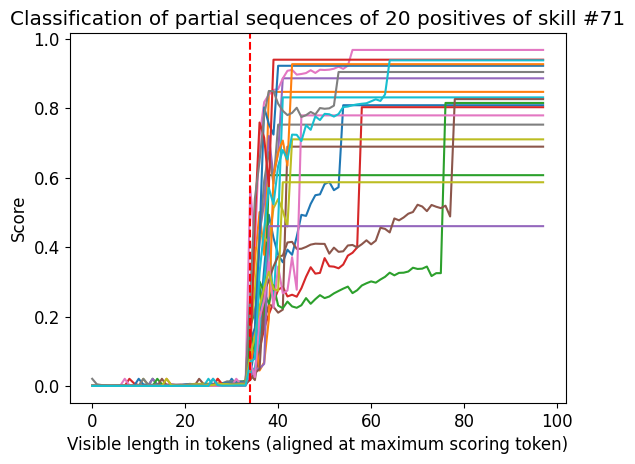

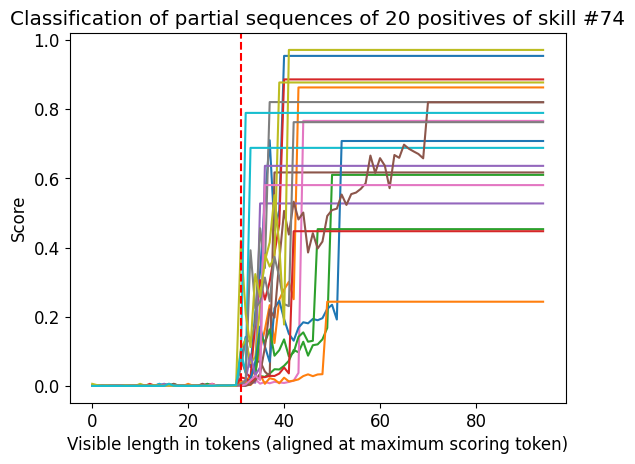

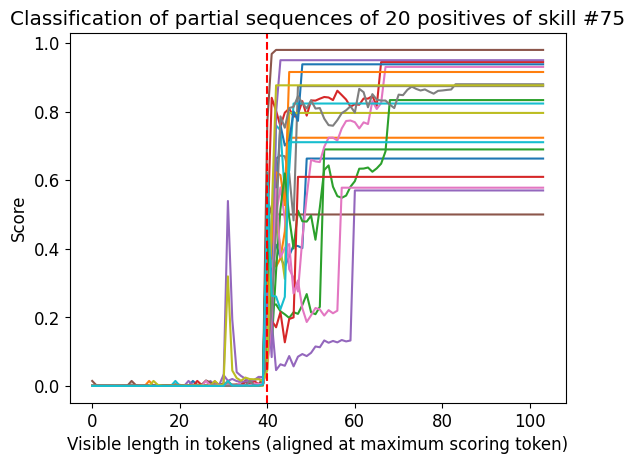

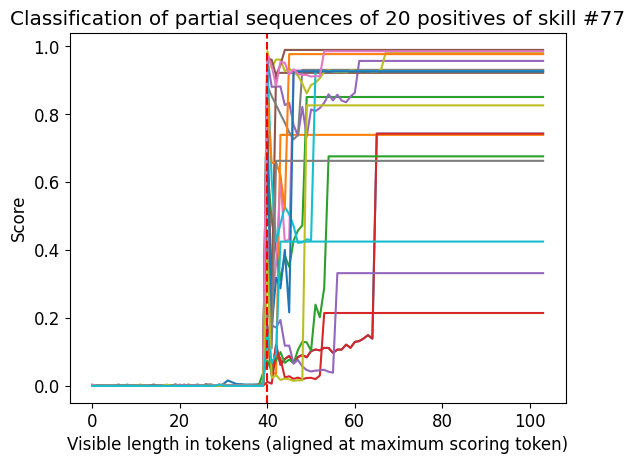

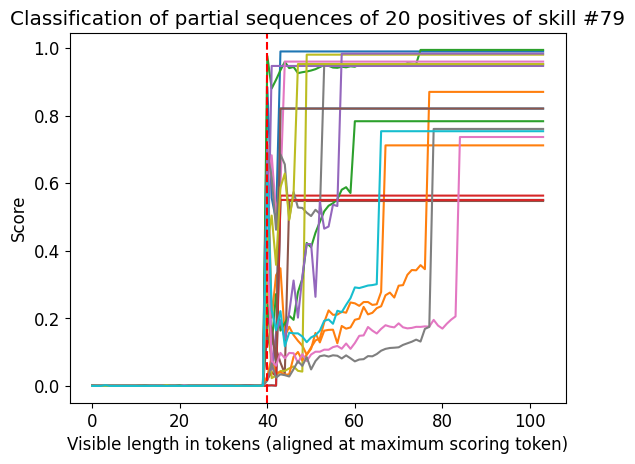

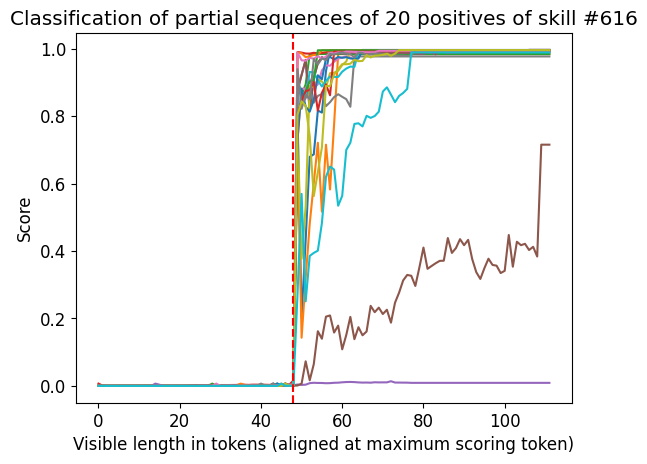

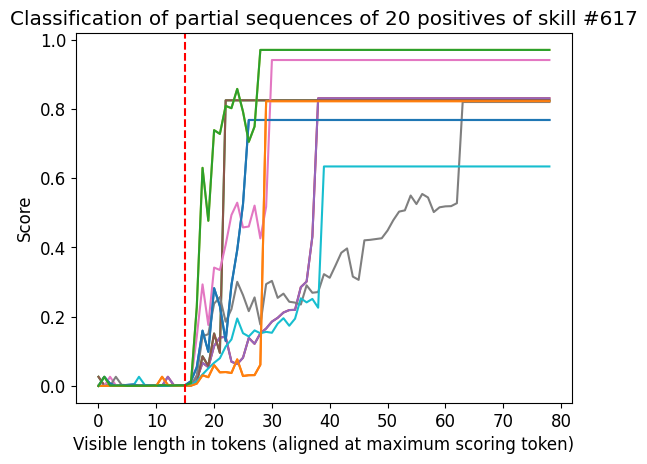

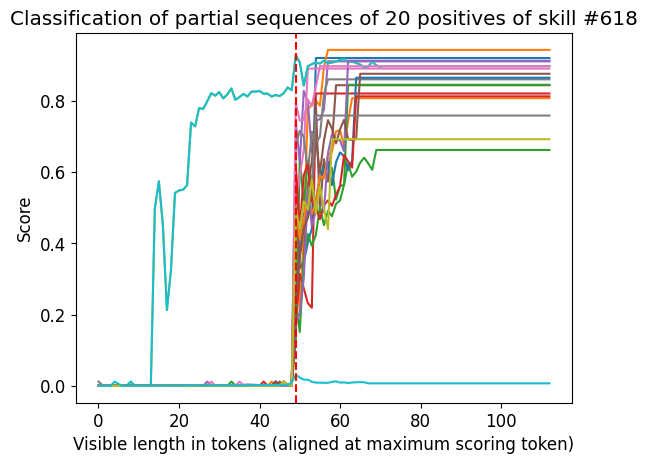

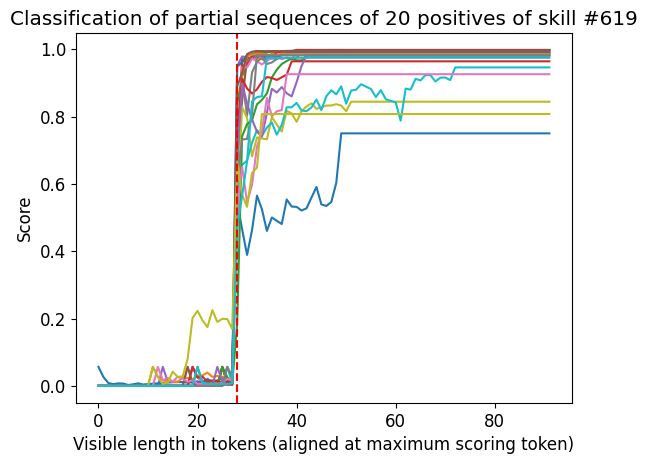

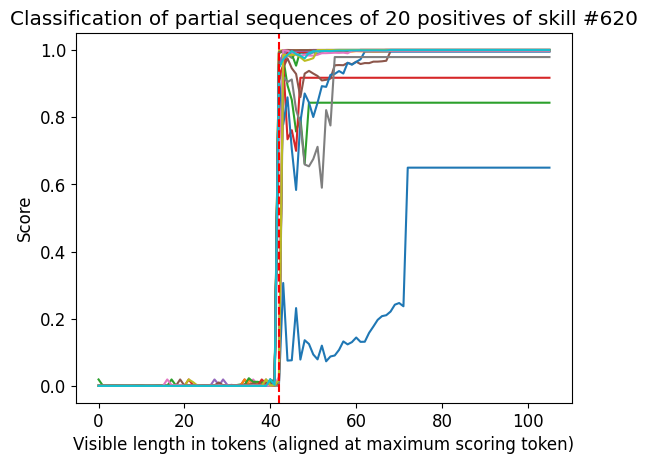

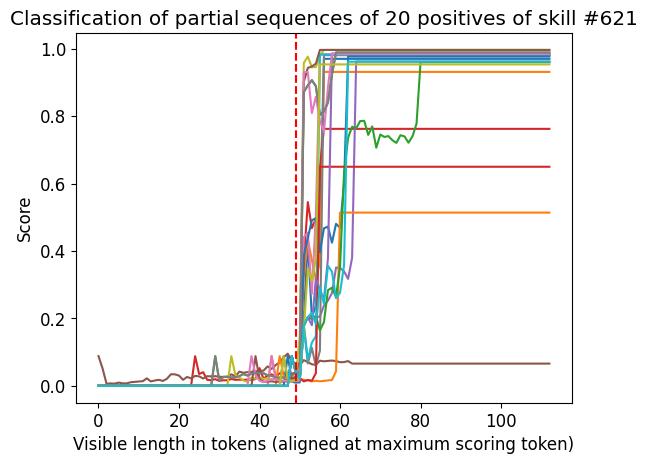

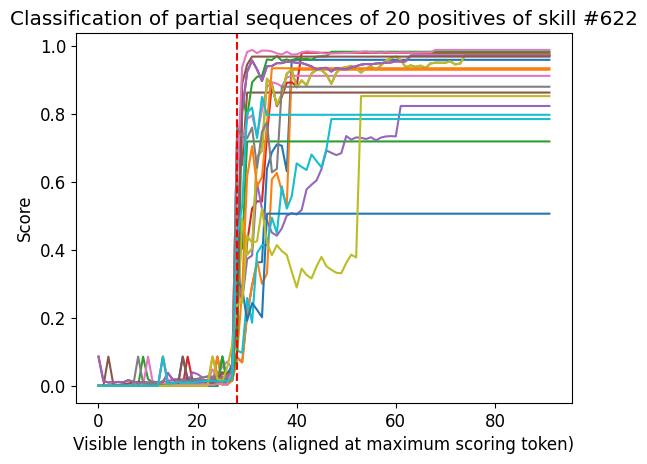

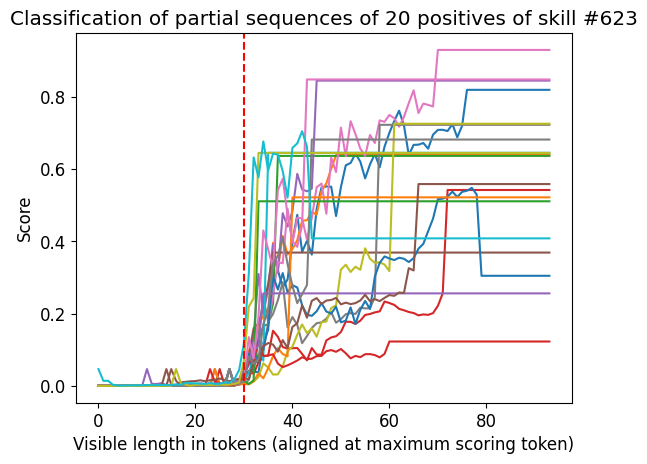

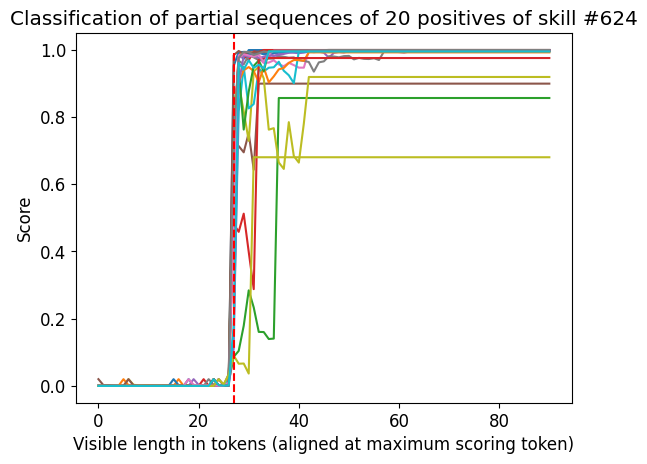

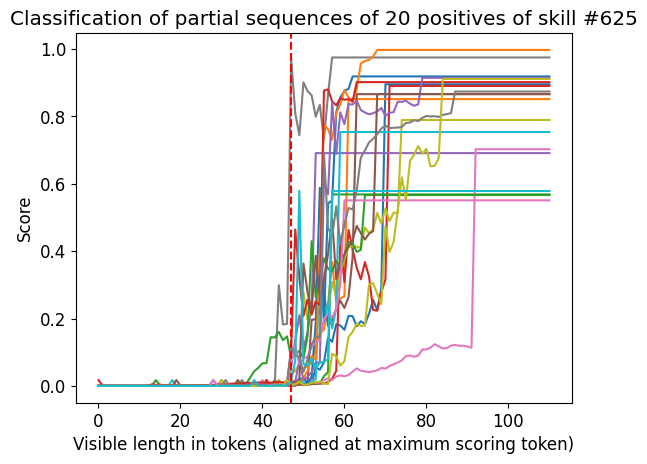

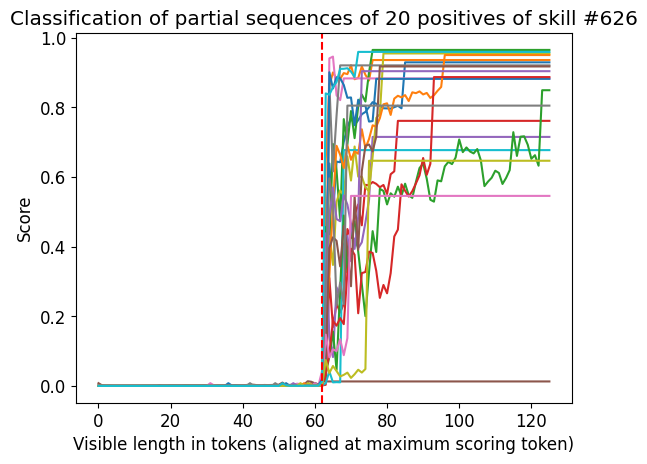

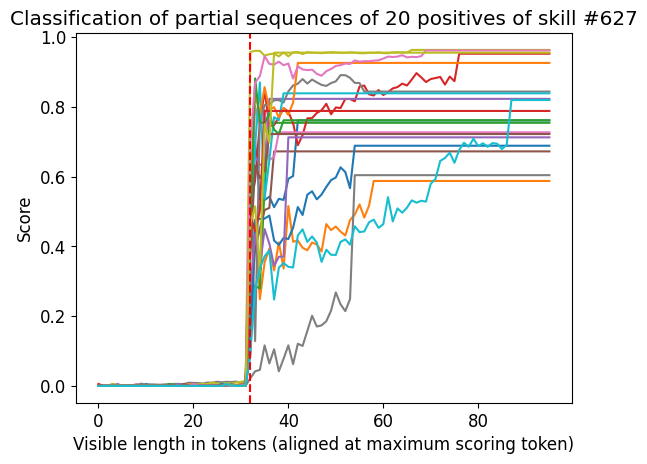

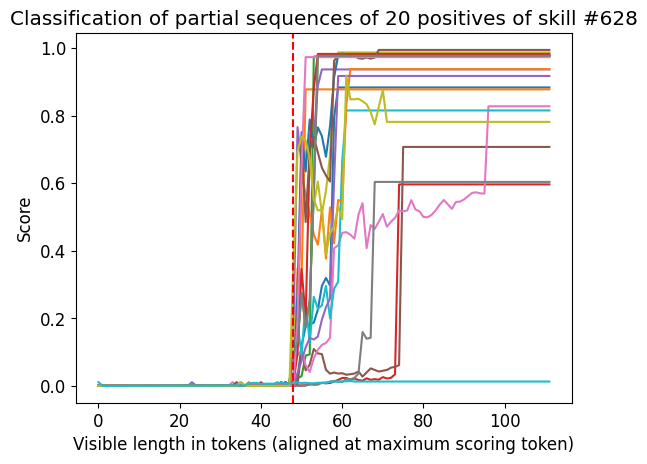

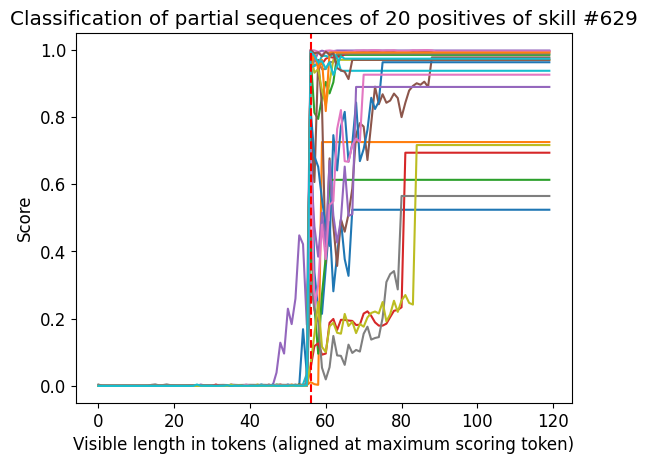

In [41]:
plt.rcParams.update({'font.size': 12})
for (nr, scores), max_tokens in tqdm(zip(partial_scores.items(), max_indices.values()), total=len(partial_scores)):
    #print(max_tokens)
    #plt.plot(get_aligned_scores(scores, max_tokens).mean(axis=0))
    plt.plot(get_aligned_scores(scores,max_tokens)[:20,:].transpose(1,0))
    plt.title(f"Classification of partial sequences of 20 positives of skill #{nr}")
    plt.ylabel("Score")
    plt.axvline(x=max(max_tokens),color='r', linestyle='--')
    plt.xlabel("Visible length in tokens (aligned at maximum scoring token)")
    plt.show()

In [47]:
import random
all_constraints = list(np.unique(dataset['constraints']))
neg_partial_scores = {}
neg_max_indices = {}

for nr in tqdm([625], desc="Constraints"):
    subset = dataset.filter(lambda item: item['constraints']!=nr)
    sents = random.sample(subset['response'], 20)
    print(sents)
    encoded_inputs = models.bert_tokenizer(sents, return_tensors='pt', max_length=64, padding='max_length', truncation=True)
    neg_partial_scores[nr] = np.zeros(encoded_inputs['input_ids'].shape)
    classifier = models.load_classifier(nr, 'corpus_training')
    
    for i in tqdm(range(neg_partial_scores[nr].shape[1]), total=neg_partial_scores[nr].shape[1], leave=False, desc="Sequence lengths"):
        corpus_dataset = TensorDataset(encoded_inputs['input_ids'][:,:i+1], encoded_inputs['attention_mask'][:,:i+1])
        corpus_dataloader = DataLoader(corpus_dataset, batch_size=batch_size, shuffle=False)
        scores = models.score_corpus(classifier, corpus_dataloader, max_positive=1e10, max_batches=10000, progress=False)
        neg_partial_scores[nr][:,i] = scores[0]
    neg_max_indices[nr] = scores[1] # only save max token for the entire sequence

Constraints:   0%|          | 0/1 [00:00<?, ?it/s]

Filter:   0%|          | 0/234775 [00:00<?, ? examples/s]

["I did not know. I do know in 1986 the estimated number of cars on the road was about 500 million. I'm sure plenty were Cadillac. ", "ya that's not that long ago, pretty crazy that youtube and netflix make up half of internet traffic, but I know I don't have cable and all I watch is youtube", 'they have yea. Theres a general assumption that if Disney or Pixar made a movie that year. theyll win the Oscar for animated feature. im not sure that will be the case this year tho....Spiderverse is looking pretty good', "Gotcha! I don't know much else but the area around downtown Santa Fe is one of the earliest known settlements! It was established around 900 AD!", 'I would have preferred to get lessons from a legend like Michael Caine', 'If you could attend any college what would it be?  I would attend the University of London.  I would love to live there', 'To be frank with you, I would like nothing better than to be an overseas reporter some day.', "That's fun!  Supposedly, country music is

Sequence lengths:   0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

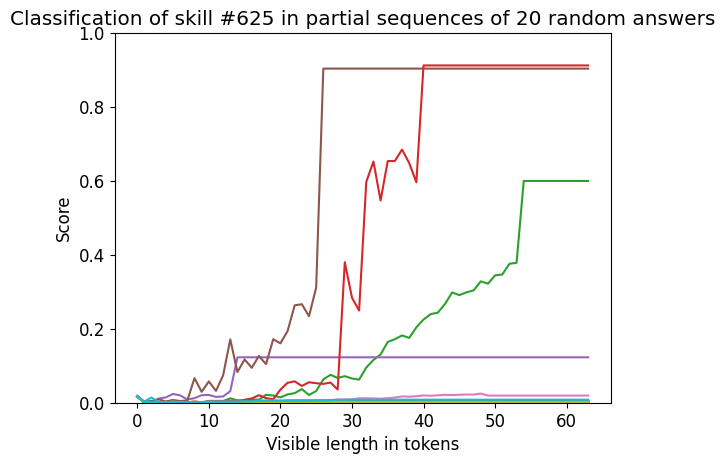

In [48]:
plt.rcParams.update({'font.size': 12})
for (nr, scores), max_tokens in tqdm(zip(neg_partial_scores.items(), neg_max_indices.values()), total=len(neg_partial_scores)):
    #print(max_tokens)
    #plt.plot(get_aligned_scores(scores, max_tokens).mean(axis=0))
    plt.plot(scores[:20,:].transpose(1,0))
    plt.title(f"Classification of skill #{nr} in partial sequences of 20 random answers")
    plt.ylabel("Score")
    plt.ylim(0,1)
    plt.xlabel("Visible length in tokens")
    plt.show()

In [2]:
# Load a model
model, tokenizer = models.load_generator()

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
input_file = "../data/task1_test.json"
output_file = "../data/task1_test_decoding.json"
max_rows=5
if os.path.exists(output_file):
    original_testset = pd.read_json(input_file)
    testset = pd.read_json(output_file)
    cols_to_assert = ['context', 'constraints']
    assert_frame_equal(testset[cols_to_assert], original_testset[cols_to_assert])
else:
    testset = pd.read_json(input_file)
    testset['responses'] = [[]] * len(testset)

condition = testset['responses'].apply(len)==0
max_rows = min(max_rows, len(testset))
remaining_testset = testset[condition]
for idx, case in tqdm(remaining_testset.iterrows(), total=max_rows-(~condition).sum()):
    if idx >= max_rows: break
    prompt = helpers.get_generation_prompt(case)['prompt']
    constraints = case['constraints']

  0%|          | 0/5 [00:00<?, ?it/s]

In [4]:
print(prompt)

[INST] Write the response of A and include these grammatical items in the response:
- superlatives - FORM/USE: 'THE BEST' WITH NOUN AND PRESENT PERFECT: Can use 'the best' before a noun + present perfect to talk about a unique experience.B1
- superlatives - FORM/USE: WITH NOUN AND POSTMODFIER: Can use a postmodifier to make the superlative stronger in the structure superlative + postmodifier + noun. C1
- would - FORM/USE: AFTER 'IF' CLAUSES: Can use 'would' in the main clause of a conditional sentence to talk about an imagined situation, often in the context of advice or opinion-giving.B1
- would - USE: POLITE REQUESTS: Can use 'would' to make polite requests, often in the fixed expression 'would you mind'.B1
Dialog:
A: It was a melodrama filmed entirely in a Burbank Ikea store, without the store knowing!  Pretty wild,. You could be an employee at Ikea and not even know you are a TV star!
B: wow, that is very different. do you like dogs?
A: I love dogs. I have a GSD.  Did you know a do

In [5]:
constraints

[70, 77, 625, 633]

In [7]:
input_ids = tokenizer.encode(prompt, return_tensors="pt")
input_len = input_ids.shape[1]
p=0.9

with torch.no_grad():
    model.eval()
    for _ in range(10):
        output = model(input_ids, use_cache=True)
        prediction = output.logits[:,-1,:]

        probs = torch.softmax(prediction, dim=-1)
        sorted_probs, sorted_indices = torch.sort(probs, descending=True)
        cumulative_probs = torch.cumsum(sorted_probs, dim=-1)
        sorted_indices_to_remove = cumulative_probs > p
        sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
        sorted_indices_to_remove[..., 0] = 0
        indices_to_remove = sorted_indices_to_remove.scatter(1, sorted_indices, sorted_indices_to_remove)
        probs[indices_to_remove] = 0
        probs /= probs.sum(dim=-1, keepdim=True)
        candidate_tokens = torch.where(probs>0)[1]
        print(len(candidate_tokens))
        candidate_sequences = torch.cat([input_ids[:,input_len:].expand(len(candidate_tokens), -1), torch.where(probs>0)[1].unsqueeze(1)], dim=-1)
        candidates = tokenizer.batch_decode(candidate_sequences)
        
        k=100
        top_k = torch.topk(prediction, k, dim=-1).indices
        #candidates = tokenizer.batch_decode(torch.cat([input_ids[:,input_len:].expand(k, -1), top_k.transpose(0,1)], dim=-1))
        #print(candidates)
        scores = evaluation.detector.score_texts(candidates, constraints)
        for nr, score in scores.items():
            if (score[0]>0.05).any().item():
                print(nr)
                print([candidates[idx] for idx in torch.where(score[0]>0.05)[0].tolist()])
        
        selected_token = top_k[:,0]
        if selected_token == 2: break
        input_ids = torch.cat((input_ids, torch.tensor([[selected_token]])), dim=1)
        text = tokenizer.batch_decode(input_ids[:,input_len:])[0]
        print(text)
        if text[-2:] == "B:":
            break 

1091


OutOfMemoryError: CUDA out of memory. Tried to allocate 820.00 MiB (GPU 0; 10.75 GiB total capacity; 8.23 GiB already allocated; 261.62 MiB free; 9.38 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

[18]

In [266]:
score[0]>0.1

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False,  True, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False])

In [217]:
top_k.transpose(0,1).shape

torch.Size([5, 1])

In [220]:
torch.cat([x, top_k.transpose(0,1)], dim=-1)

tensor([[28741, 28747, 28705,  3840],
        [28741, 28747, 28705,  1725],
        [28741, 28747, 28705,  6087],
        [28741, 28747, 28705,   369],
        [28741, 28747, 28705,   315]])

In [187]:
torch.cat((input_ids.unsqueeze(1).expand(-1, k, -1), top_k.unsqueeze(-1)), dim=-1)

tensor([[[    1,   733, 16289,  ..., 28760, 28747, 28747],
         [    1,   733, 16289,  ..., 28760, 28747,  4049],
         [    1,   733, 16289,  ..., 28760, 28747, 19746],
         [    1,   733, 16289,  ..., 28760, 28747, 12813],
         [    1,   733, 16289,  ..., 28760, 28747,   714]]])

In [178]:
input_ids.unsqueeze(1).expand(-1, k, -1).shape

torch.Size([1, 5, 270])